<center><h1>SINGING VOICE TRANSCRIPTION USING DEEP NEURAL NETWORKS</h1></center> 

<h1><center>Implementation</center></h1>

CODE AUTHOR: Shayenne Moura, Computer Music Group, University of São Paulo/Brazil

*Original article by François Rigaud and Mathieu Radenen, ISMIR 2016.*

This poster presents an implementation of a system for singing voice melody transcription based on an article published in ISMIR 2016. This system is not the original one from the paper, since details of implementation are not available. The main goal was to evaluate the reproducibility of articles published without source code.

### Introduction

The main task of this system is to estimate the main melody, i.e., sequences of fundamental frequency ($f_0$) where voice or melodic instrument are active.

The realized approach was based in a supervised classification problem. It means that the system need to assign a pitch class for each frame if melody is present, otherwise, unvoiced class.

### System description

I implemented a system proposed as illustrated in figure below. Two Deep Neural Networks (DNNs) are composed in parallel for identify melodic sequences in polyphonic music.

<img src="img/systemDNN.png" alt="System Overview" style="width: 300px;"/>

The Voice Activity Detection (VAD) DNN is responsible for deciding which frames are voiced or unvoiced.

The F0 estimation DNN is responsible for classifying a frequency class for each frame.

### Preprocess audio signal

In [1]:
# Import libraries and modules    
from librosa import *            # Manipulate and display audio files
import librosa.display
import scipy                     # Utilize signal functions
import matplotlib.pyplot as plt  # Plot graphics
%matplotlib inline
import numpy as np               # Manipulate arrays efficiently
import os, glob                  # Find files in directories
import IPython                   # Display audio file in notebook
import csv                       # Manipulate .csv files
import pandas as pd               # Manipulate data as matrix


# Keras modules
from keras.models import Model, Sequential, model_from_json, load_model

# Put your audio file path 
your_path = "../www/nips/"
file_path = your_path + "MusicDelta_Rockabilly_MIX.wav" 

Using TensorFlow backend.


##### Steps to pre process the input data

1. Converted to mono
1. Re-sampled to 16kHz
1. Double-stage Harmonic/Percussive Source Separation
    - $h_1$ and $p_1$ (FFT using window of 256ms) by re-sampled signal
    - $h_2$ and $p_2$ (FFT using window of 256ms) by $p_1$ signal reconstructed
    
    
*Intuition:* This double-stage Harmonic/Percussive Source Separation enhances the separation between more stationary/stable sounds (the harmonic background) and more percussive instruments (such as drum). Melodic signals are usually present on $h_2$ spectrogram.

In [2]:
print ("--- Preprocessing...")
print (file_path)
    
# Preprocess audio signal
y, sr = librosa.load(file_path, mono=True) # Converted to mono
y_16k = librosa.resample(y, sr, 16000)
sr = 16000

print ("> Audio signal loaded...")

# Applying HPSS separation
# High frequency resolution - more clearly the frequencies
print ("> First HPSS decomposition (high-frequency resolution)...")

# STFT with Hamming window of 256ms (4096 samples) with overlap 0,75 (hop 0.25)
s = librosa.stft(y_16k, n_fft=4096, hop_length=int(4096/4), window=scipy.signal.hamming(4096))
h1, p1 = librosa.decompose.hpss(s)
    
    
# P1 here has other frequency resolution
print ("> Second HPSS decomposition (high-frequency resolution)...")
# Getting signal - need arguments of stft
p1_inverse = librosa.istft(p1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))
h1_inverse = librosa.istft(h1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))


# STFT with Hamming window of 32ms (512 samples) with overlap 0,75 (hop 0.25)
p1_32 = librosa.stft(p1_inverse, n_fft=512, hop_length=int(512/4), window=scipy.signal.hamming(512))
h2, p2 = librosa.decompose.hpss(p1_32)   

# Getting signal separated - need arguments of stft
h2_inverse = librosa.istft(h2, hop_length=int(512/4), window=scipy.signal.hamming(512))
p2_inverse = librosa.istft(p2, hop_length=int(512/4), window=scipy.signal.hamming(512))

--- Preprocessing...
../www/nips/MusicDelta_Rockabilly_MIX.wav
> Audio signal loaded...
> First HPSS decomposition (high-frequency resolution)...
> Second HPSS decomposition (high-frequency resolution)...


##### Steps to pre process input for VAD

For each of the reconstructed signals $h_1$, $h_2$ and $p_2$, timbral features are computed:
   - MFCCs with 32ms Hamming windows, 0.75 of overlap, 40 triangular filters on mel scale between 0 and 8kHz.
   - MFCCs, as describe above, normalized using mean and variance over its values.

In [3]:
""" Input for VAD """    
# The input for VAD is the whole signal s = h1 + h2 + p2 in MFCC features
h1_mfcc = librosa.feature.melspectrogram(y=h1_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)
h2_mfcc = librosa.feature.melspectrogram(y=h2_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)
p2_mfcc = librosa.feature.melspectrogram(y=p2_inverse, sr=sr, n_fft=512, hop_length=128, n_mels=40, fmax=8000)

## Rescale done for VAD (Better results)
h1_mfcc = h1_mfcc - h1_mfcc.mean()
h1_mfcc = h1_mfcc / h1_mfcc.std()  

h2_mfcc = h2_mfcc - h2_mfcc.mean()
h2_mfcc = h2_mfcc / h2_mfcc.std()  

p2_mfcc = p2_mfcc - p2_mfcc.mean()
p2_mfcc = p2_mfcc / p2_mfcc.std()  
    
# Write mfcc file
with open(file_path[:-4]+'_mfcc.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    col = h1_mfcc.shape[1]
    row = np.ndarray(shape=(3*40,))
    for i in range(col):
        row[  :40] = h1_mfcc[:,i]
        row[40:80] = h2_mfcc[:,i]
        row[80:  ] = p2_mfcc[:,i]
        spamwriter.writerow(row) ### Put the mfcc from h1+h2+p2

##### Steps to pre process input for F0-estimation

For each signal $p_1$, the features selected are:
   - Log-spectrograms with 64ms Hamming windows and 0.75 of overlap [without discarting]
   - Rescaled between 0 and 1

In [4]:
""" Input for F0-Detection """    
# Getting signal - need arguments of stft - Not discarting frequencies above 4kH
p1_toF0_inverse = librosa.istft(p1, hop_length=int(4096/4), window=scipy.signal.hamming(4096))

# STFT with Hamming window of 64ms (1024 samples) with overlap 0,75 (hop 0.25)
p1_toF0 = librosa.stft(p1_toF0_inverse, n_fft=1024, hop_length=int(1024/4), window=scipy.signal.hamming(1024))
# Log-spectrogram
p1_toF0_log = librosa.amplitude_to_db(p1_toF0, ref=np.max)
    
## Rescale done for F0 Detection Model (Not cutted)
p1_toF0_log = p1_toF0_log - p1_toF0_log.min()
p1_toF0_log = p1_toF0_log / p1_toF0_log.max()  
    

# Write features file 
with open(file_path[:-4]+'_features.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    col = p1_toF0_log.shape[1]
    for i in range(col):
        spamwriter.writerow(p1_toF0_log[:,i])

### Training Step

<span style="color:red">** IMPORTANT **</span>

The training step is presented here only for visualization. The real training was made separatelly, using the Python script on the repository. The code presented below is a transcription from the one really used for training the deep neural networks. 

### VAD Training

### F0-estimation Training

The training phase was visualized using TensorBoard. The graphs generated were the following:

In the graphs below, it is shown the accuracy value of train and validation sets for each epoch of training. Graphs below shows the results for VAD training during 25 epochs, with two different data: first, using normalized MFCCs as input (mean 0 and std 1 in data values) and MFCCs with their real values. Clearly, training using normalization improves the learning task, besides validation set accuracy continues unacceptable.
<table>
<tr>
<td>
<img src="img/vad_acc_train.png" alt="VAD train" style="width: 300px;"/> 
</td>
<td>
<img src="img/vad_acc_val.png" alt="VAD validation" style="width: 300px;"/>
</td>
</tr>
</table>
<img src="img/vad_sub.png" alt="VAD subtitle" style="width: 300px;"/>

Graphs below presents values of accuracy on training F0-detection DNN. As observed, training using Adam optimization performs better even with only 100 epochs. 

<table>
<tr>
<td>
<img src="img/f0_acc_train.png" alt="F0 train" style="width: 300px;"/>
</td>
<td>
<img src="img/f0_acc_val.png" alt="F0 validation" style="width: 300px;"/>
</td>
</tr>
</table>
<img src="img/f0_sub.png" alt="F0 subtitle" style="width: 300px;"/>

# Making Predictions

The melodic line was given by the results of these two DNNs composed.

### VAD results 

The voice estimation is done by the following steps:

 1. Load and compile the VAD DNN;
 1. Load the features of the music to be estimated;
 1. Normalize the features to feed the DNN;
 1. Predict the probability of being voiced;
 1. Threshold frames with probability greater than 0.5 as voiced.

In [5]:
# load json and create model
json_file = open(your_path+'25SVD2model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_svd = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_svd.load_weights(your_path+"25SVD2model.h5")
print("Loaded model from disk")

# compile loaded model with the same parameters
loaded_model_svd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [6]:
# Load data to classify
df1 = pd.read_csv(file_path[:-4]+"_mfcc.csv", header=None)
X = pd.DataFrame.as_matrix(df1)
print (X.shape)

(3241, 120)


In [7]:
# Data Normalization - necessary! (Better results on network training) 
meanDF = X - np.mean(X, axis=0).reshape(1, X.shape[1])
X  = meanDF / np.std(meanDF, axis=0).reshape(1, X.shape[1])

In [8]:
# calculate predictions
voiced = loaded_model_svd.predict(X)

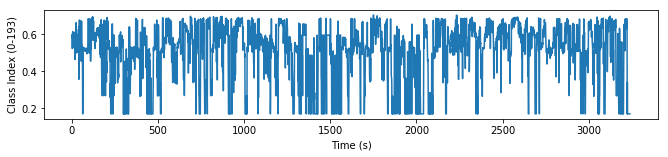

In [9]:
# Plot probability of voice presence
plt.figure(figsize=(11,2))
plt.plot(voiced)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

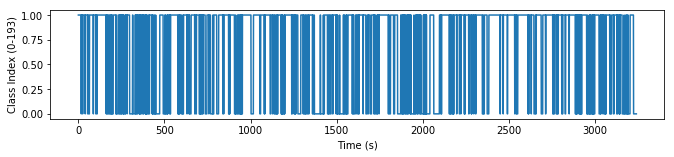

In [10]:
# Activation output - need to be 0.5
vcd = voiced.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(vcd)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures to evaluate the result

Following cells present a small evaluation of the results from VAD DNN.

First, load the piece labels to compare with the voice estimated here.

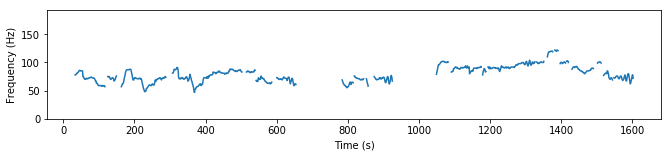

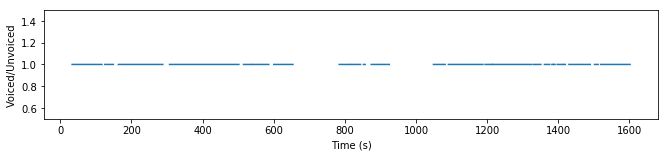

In [11]:
# Get labels to compare
annot = your_path+"MusicDelta_Rockabilly_labels.csv"

labels = [] # Notes are present
lbl    = [] # Only voiced/unvoiced

with open(annot) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels.append(float(row[0]))
        
for i in range(len(labels)):
    if labels[i] <= 0:
        labels[i] = None
        lbl.append(None)
    else:
        lbl.append(1)
        
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

# Plot voiced line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0.5,1.5])
plt.plot(lbl[::2])
plt.xlabel('Time (s)')
plt.ylabel('Voiced/Unvoiced')
plt.show()

Now, are calculated TN (true negatives), TP (true positives), FN (false negatives), FP (false positives).

Preseting different measures:
 1. P: Precision
 1. R: Recall
 1. F: F-measure
 1. FA: False Alarm Rate
 1. VA: Voicing Accuracy
 1. OA: Overall Accuracy

In [12]:
# We have the same value of voiced frames and labeled frames!!!
TN, TP, FN, FP = 0, 0, 0, 0

res = vcd.copy()

for j in range(len(res)):
    if lbl[j] is None:
        lbl[j] = 0
    if res[j] == lbl[j]:
        if lbl[j] == 0:
            TN += 1
        else:
            TP += 1
    else:
        if lbl[j] == 0:
            FP += 1
        else:
            FN += 1
        
P = TP/(TP+FP)
R = TP/(TP+FN)
F = 2*P*R/(P+R)
FA = FP/(TN+FP)
VA = TP/(TP+FN)
OA = TP + TN / (len(lbl))
print ("Precision:    {}".format(P))
print ("Recall:       {}".format(R))
print ("F-measure:    {}".format(F))
print ("Voicing False Alarm Rate:  {}".format(FA))  
print ("Voicing Recall Rate:       {}".format(VA))
print ("Overall Accuracy:          {}".format(OA))


# All measures are based on mir_eval formulas
import mir_eval

ref_voicing, est_voicing = np.array(list(map(bool,lbl))), np.array(list(map(bool,res)))

recall, false_alarm = mir_eval.melody.voicing_measures(ref_voicing, est_voicing)
print ()
print ("Comparing with some mir_eval measures: ")
print ("Voicing False Alarm Rate:  {}".format(false_alarm))  
print ("Recall:       {}".format(recall))


Precision:    0.8007165248544559
Recall:       0.772020725388601
F-measure:    0.7861068366673993
Voicing False Alarm Rate:  0.4810810810810811
Voicing Recall Rate:       0.772020725388601
Overall Accuracy:          1788.1481024375194

Comparing with some mir_eval measures: 
Voicing False Alarm Rate:  0.4810810810810811
Recall:       0.772020725388601


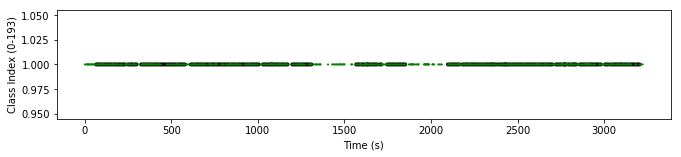

In [13]:
# Plot melodic line from annotation
lbl = [x if x == 1 else None for x in lbl]
res = [x if x == 1 else None for x in res]# Adjust for visualization

plt.figure(figsize=(11,2))
plt.plot(lbl, solid_capstyle="round", linewidth=4, color='black')
plt.plot(res, solid_capstyle="round", linewidth=2, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### F0 prediction

The F0-line estimation is done by the following steps:

 1. Load and compile the F0-estimation DNN;
 1. Load the MFCCs of the music to be estimated;
 1. Normalize the features to feed the DNN (made on preprocess); 
 1. Predict the probability distribution for each frame;
 1. Get the most probable class on this distribution;
 1. Apply Viterbi algorithm to smooth the estimated line.

In [14]:
# Load json and create model
json_file = open(your_path+'f0modelNEW.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_f0 = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model_f0.load_weights(your_path+"f0modelNEW.h5")
print("Loaded model from disk")
    
# Compile loaded model with the same parameters
loaded_model_f0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [15]:
# Load data to classify
df1=pd.read_csv(file_path[:-4]+"_features.csv",header=None)
X=pd.DataFrame.as_matrix(df1)
print (X.shape)

(1621, 513)


In [16]:
# Calculate predictions
predictions = loaded_model_f0.predict(X)

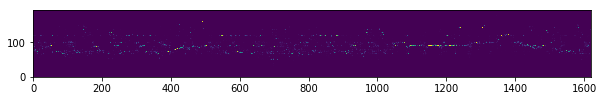

In [17]:
# Plot the grid
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(predictions), origin='lower')
plt.show()

In [18]:
# Max probability line
ynotes = np.argmax(np.transpose(predictions), axis=0)

### Viterbi Algorithm

In [19]:
# This code was copied from https://jyyuan.wordpress.com/2014/01/22/viterbi-algorithm-finding-most-likely-sequence-in-hmm/
def viterbi_alg(A_mat, O_mat, observations):
    # get number of states
    num_obs = observations.size
    num_states = A_mat.shape[0]
    # initialize path costs going into each state, start with 0
    log_probs = np.zeros(num_states)
    # initialize arrays to store best paths, 1 row for each ending state
    paths = np.zeros( (num_states, num_obs+1 ))
    paths[:, 0] = np.arange(num_states)
    # start looping
    for obs_ind, obs_val in enumerate(observations):
        # for each obs, need to check for best path into each state
        for state_ind in range(num_states):
            # given observation, check prob of each path
            temp_probs = log_probs + \
                         np.log(O_mat[state_ind, obs_val]) + \
                         np.log(A_mat[:, state_ind])
            # check for largest score
            best_temp_ind = np.argmax(temp_probs)
            # save the path with a higher prob and score
            paths[state_ind,:] = paths[best_temp_ind,:]
            paths[state_ind,(obs_ind+1)] = state_ind
            log_probs[state_ind] = temp_probs[best_temp_ind]
    # we now have a best stuff going into each path, find the best score
    best_path_ind = np.argmax(log_probs)
    # done, get out.
    return (best_path_ind, paths, log_probs)

In [20]:
####    Viterbi post processing    ###

# Log-probabilities matrix
trans_mtx = np.ones((193 ,193))
for k in range(193):
    for l in range(193):
        trans_mtx[k][l] = 1/abs(k-l+0.1)

# Make the signal smooth
best_path_ind, paths, log_probs = viterbi_alg(trans_mtx, trans_mtx, ynotes)
print ("obs1 is " + str(ynotes))
print ("obs1, best path is" + str(paths[best_path_ind,:]))

obs1 is [ 99 119 120 ..., 138 138 129]
obs1, best path is[ 118.  118.  119. ...,  138.  138.  130.]


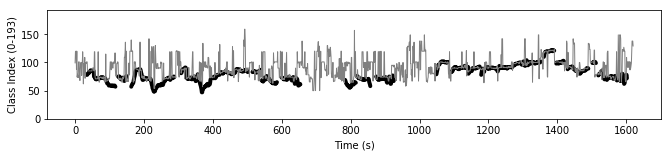

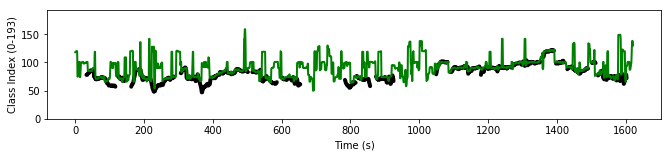

In [21]:
# Plot melodic line from annotation and result
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=4, color='black')
plt.plot(ynotes, solid_capstyle="round", linewidth=1, color='gray')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=4, color='black')
plt.plot(paths[best_path_ind,:], solid_capstyle="round", linewidth=2, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures to evaluate F0-estimation results


Following cells present a small evaluation of the results from F0-estimation DNN.

Comparing different measures (with and without Viterbi tracking):
 1. RPA: Raw Pitch Accuracy
 1. RCA: Raw Chroma Accuracy

In [22]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# RAW CHROMA ACCURACY (error less than a half of a semitone, in different octaves)

# Since the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct
def rpa_rca_measures(lbl, res): 
    acc     = 0
    acc_chr = 0
    vstar   = 0

    for j in range(len(ynotes)):
        if lbl[j] is not None:
            vstar += 1
            if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
                acc += 1
            ## Eight parts of tone, 12 semitones
            if res[j]%(4*12) >= lbl[j]%(4*12)-2 and res[j]%(4*12) <= lbl[j]%(4*12)+2: 
                acc_chr += 1
    
    print ("Raw Pitch Accuracy:", acc/vstar)   
    print ("Raw Chroma Accuracy:", acc_chr/vstar)

In [23]:
# Accuracy from network's output
rpa_rca_measures(labels[::2], ynotes)

Raw Pitch Accuracy: 0.46453287197231835
Raw Chroma Accuracy: 0.504325259515571


In [24]:
# Accuracy from Viterbi smooth
rpa_rca_measures(labels[::2], paths[best_path_ind,:])

Raw Pitch Accuracy: 0.5025951557093425
Raw Chroma Accuracy: 0.5354671280276817


### Final result

The complete estimation is composed by the DNNs results: **all frequencies estimated when voice is present**

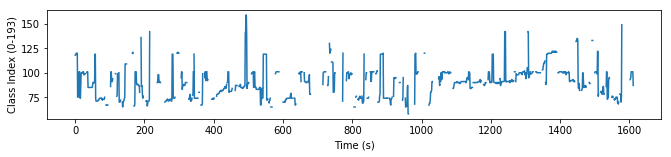

In [25]:
# We have doubled vocal answers
final = []

for j in range(len(ynotes)):
    final.append(vcd[::2][j]*float(paths[best_path_ind,:][j]))
    if final[j] == 0:
        final[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(final)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

## Observations
I would like to talk about:

 - Datasets
 - Computation time
 - Number of epochs

### Datasets

The article cites four datasets: RWC Popular Music and Roalty Free Music, MIR-1k, MedleyDB and iKala. 

However, there is no description of how these datasets are used on training and validation steps. 

The first, RWC Popular Music and Roalty Free Music, is not free.  I had access to all other, but I did not used them because it spend a huge computation time.

### Computation time

To train the networks, I spent much time, even using a gpu to make the network's weights computation. The time grew exponencially related to the size of data input. It was one, if not the biggest, problem to deal during this implementation.

### Number of epochs

There is not any information about the number of epochs to train the VAD network. The article cited by the authors as reference has only the information about avoid overfitting issues. 

For the F0-estimation task, the article suggests 10.000 epochs, which are costly, even with few data.  


## Conclusions

There is a barrier in transforming scientific publications on real systems, accessible and usable. Without detailed information or open source systems we will always lose time doing everything again. 